# Lets make a distribution analysis
* Fragment 5 - 70KeV - 3.24μM
* 20231210132040 - 53KeV - 7.91μΜ
So we need to resize them to match their dimensions.

In [61]:
import utils

class CFG:
    # ============== comp exp name =============
    current_dir = './'
    segment_path = './train_scrolls/'
    
    start_idx = 30
    in_chans = 4
    
    size = 224
    tile_size = 224
    stride = tile_size
    
    # Size of fragments
    frags_ratio1 = ["rem",'frag','rect']
    frags_ratio2 = ['nothing']
    ratio1 = 1
    ratio2 = 1
    
    # ============== fold =============
    segments = ['frag5', 'vals42'] 
    valid_id = 'vals42'
    
    # ============== fixed =============
    seed = 0
    
frag5_images, frag5_masks, s4_images, s4_masks, s4_xyxys = utils.get_train_valid_dataset(CFG)
CFG.segments = ['left']
frag1_images, frag1_masks, _,_,_ = utils.get_train_valid_dataset(CFG)
print(frag5_images[0].shape)

reading frag5


100%|██████████| 4/4 [00:00<00:00, 13.86it/s]


 Shape of frag5 segment: (7392, 4704, 4)
(7392, 4704)
reading vals42


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


 Shape of vals42 segment: (5152, 12096, 4)
(5152, 12096)
reading left


100%|██████████| 4/4 [00:45<00:00, 11.36s/it]


 Shape of left segment: (26880, 27552, 4)
(26880, 27552)
(224, 224, 4)


In [50]:
print(len(frag5_images))
print(len(s4_images))
print(len(frag1_images))

125
937
22


In [51]:
import torch
f5 = torch.tensor(frag5_images[10]).to(torch.float16)
s4 = torch.tensor(s4_images[20]).to(torch.float16)
f1 = torch.tensor(frag1_images[3]).to(torch.float16)
mask_f5 = torch.tensor(frag5_masks[10])
mask_s4 = torch.tensor(s4_images[20])
mask_f1 = torch.tensor(frag1_masks[3])
print(f5.shape, s4.shape, f1.shape)

torch.Size([224, 224, 64]) torch.Size([224, 224, 64]) torch.Size([224, 224, 64])


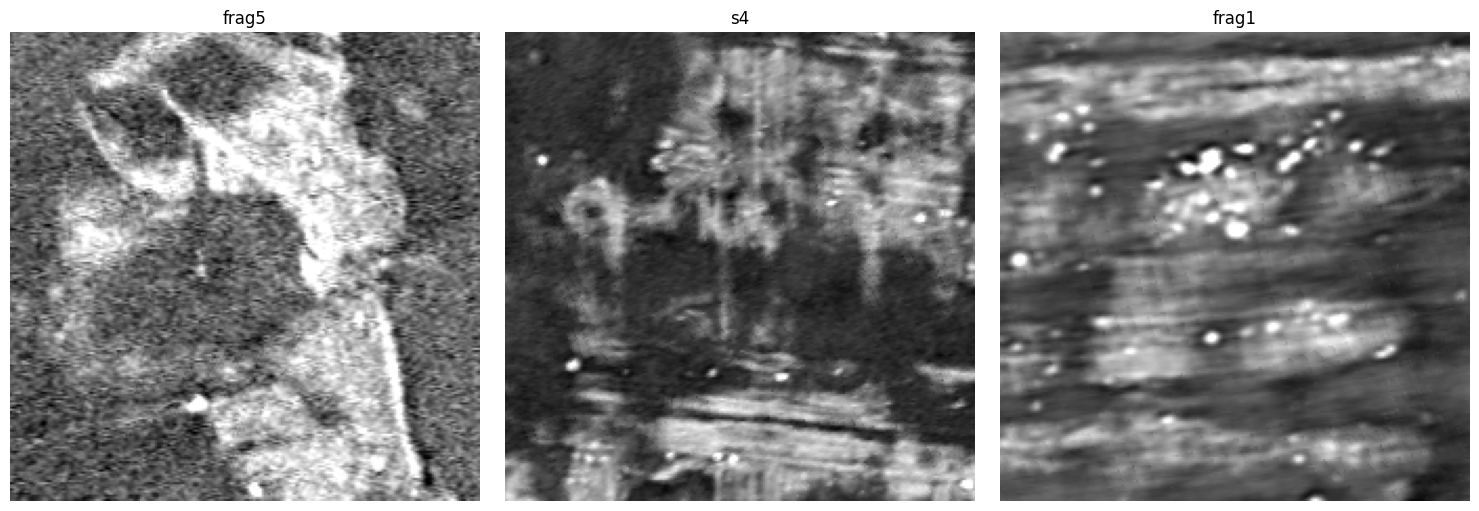

In [52]:
import matplotlib.pyplot as plt

# Pick the slice index
slice_idx = 32

# Extract 2D slices
f5_slice = f5[:, :, slice_idx].cpu().numpy()
s4_slice = s4[:, :, slice_idx].cpu().numpy()
f1_slice = f1[:, :, slice_idx].cpu().numpy()

# Plot them side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(f5_slice, cmap='gray')
plt.title("frag5")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(s4_slice, cmap='gray')
plt.title("s4")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(f1_slice, cmap='gray')
plt.title("frag1")
plt.axis('off')

plt.tight_layout()
plt.show()

As seen from the images frag5 seems to have lower contrast.

# HISTOGRAM

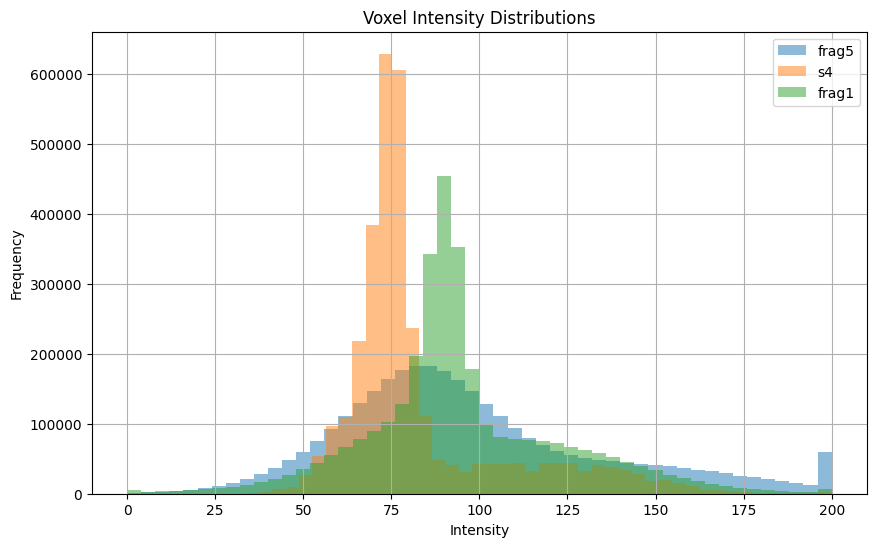

In [53]:
import matplotlib.pyplot as plt

# Flatten and convert tensors to NumPy
f5_flat = f5.flatten().cpu().numpy()
s4_flat = s4.flatten().cpu().numpy()
f1_flat = f1.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(f5_flat, bins=50, alpha=0.5, label='frag5')
plt.hist(s4_flat, bins=50, alpha=0.5, label='s4')
plt.hist(f1_flat, bins=50, alpha=0.5, label='frag1')
plt.legend()
plt.title("Voxel Intensity Distributions")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


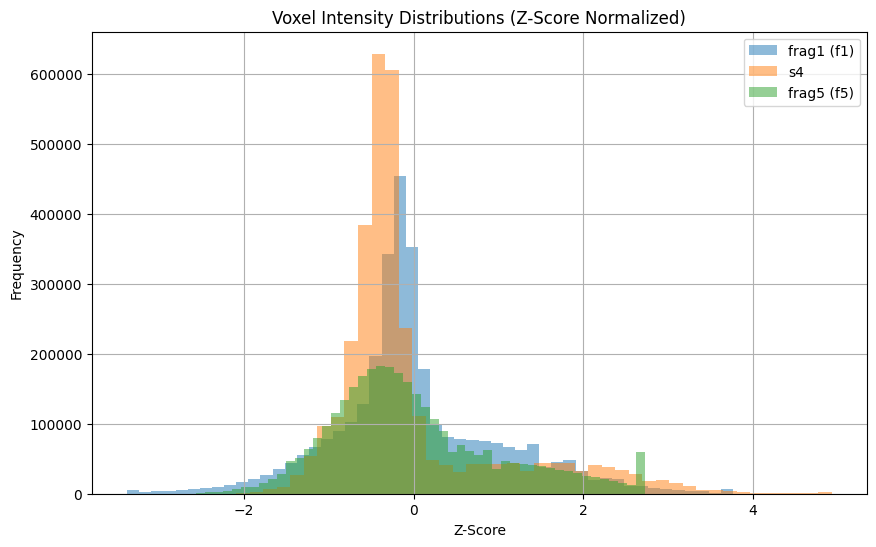

In [54]:
import torch
import matplotlib.pyplot as plt

def z_score_normalize(tensor):
    tensor = tensor.to(torch.float32)  # avoid float16 for math
    return (tensor - tensor.mean()) / tensor.std()

# Apply z-score normalization
f1_norm = z_score_normalize(f1)
s4_norm = z_score_normalize(s4)
f5_norm = z_score_normalize(f5)

# Convert to NumPy for plotting
f1_np = f1_norm.flatten().cpu().numpy()
s4_np = s4_norm.flatten().cpu().numpy()
f5_np = f5_norm.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(f1_np, bins=50, alpha=0.5, label='frag1 (f1)')
plt.hist(s4_np, bins=50, alpha=0.5, label='s4')
plt.hist(f5_np, bins=50, alpha=0.5, label='frag5 (f5)')

plt.legend()
plt.title("Voxel Intensity Distributions (Z-Score Normalized)")
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

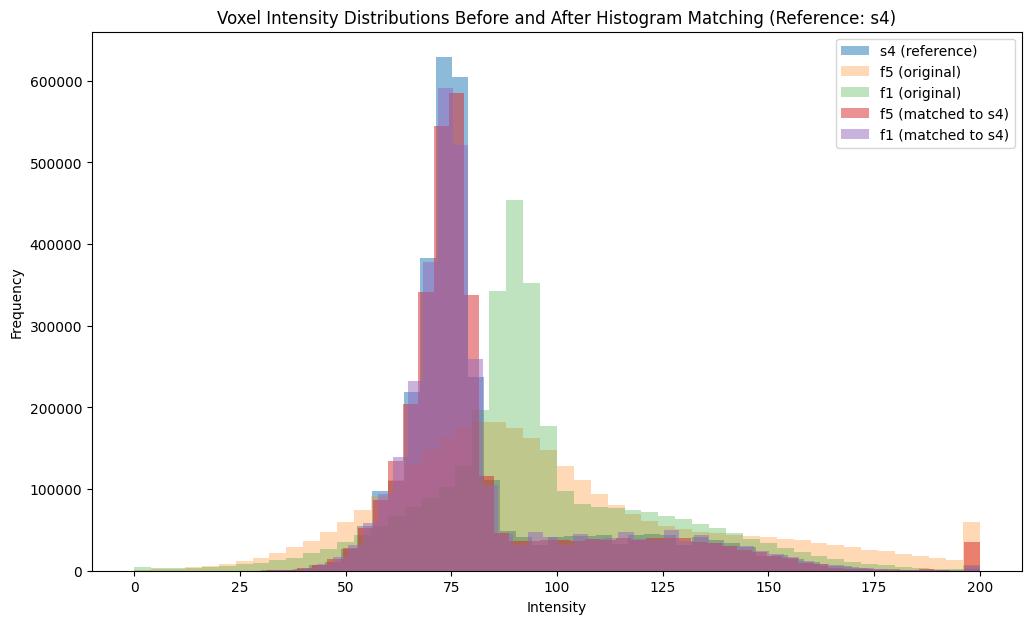

In [55]:
import torch
import numpy as np
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt

def histogram_match(source_tensor, reference_tensor):
    """
    Matches the histogram of source_tensor to reference_tensor slice-by-slice (along depth axis).
    Assumes shape (H, W, D).
    """
    source = source_tensor.cpu().numpy().astype(np.float32)
    reference = reference_tensor.cpu().numpy().astype(np.float32)
    matched = np.zeros_like(source)
    for i in range(source.shape[2]):
        matched[:, :, i] = match_histograms(source[:, :, i], reference[:, :, i], channel_axis=None)
    return torch.from_numpy(matched)

# Reference volume: s4
ref = s4

# Match f5 and f1 histograms to s4
f5_matched = histogram_match(f5, ref)
f1_matched = histogram_match(f1, ref)

# Convert all to numpy for plotting
s4_np = ref.cpu().numpy().flatten()
f5_np = f5.cpu().numpy().flatten()
f5_matched_np = f5_matched.numpy().flatten()
f1_np = f1.cpu().numpy().flatten()
f1_matched_np = f1_matched.numpy().flatten()

plt.figure(figsize=(12, 7))

# Plot original histograms
plt.hist(s4_np, bins=50, alpha=0.5, label='s4 (reference)')
plt.hist(f5_np, bins=50, alpha=0.3, label='f5 (original)')
plt.hist(f1_np, bins=50, alpha=0.3, label='f1 (original)')

# Plot matched histograms
plt.hist(f5_matched_np, bins=50, alpha=0.5, label='f5 (matched to s4)')
plt.hist(f1_matched_np, bins=50, alpha=0.5, label='f1 (matched to s4)')

plt.legend()
plt.title("Voxel Intensity Distributions Before and After Histogram Matching (Reference: s4)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


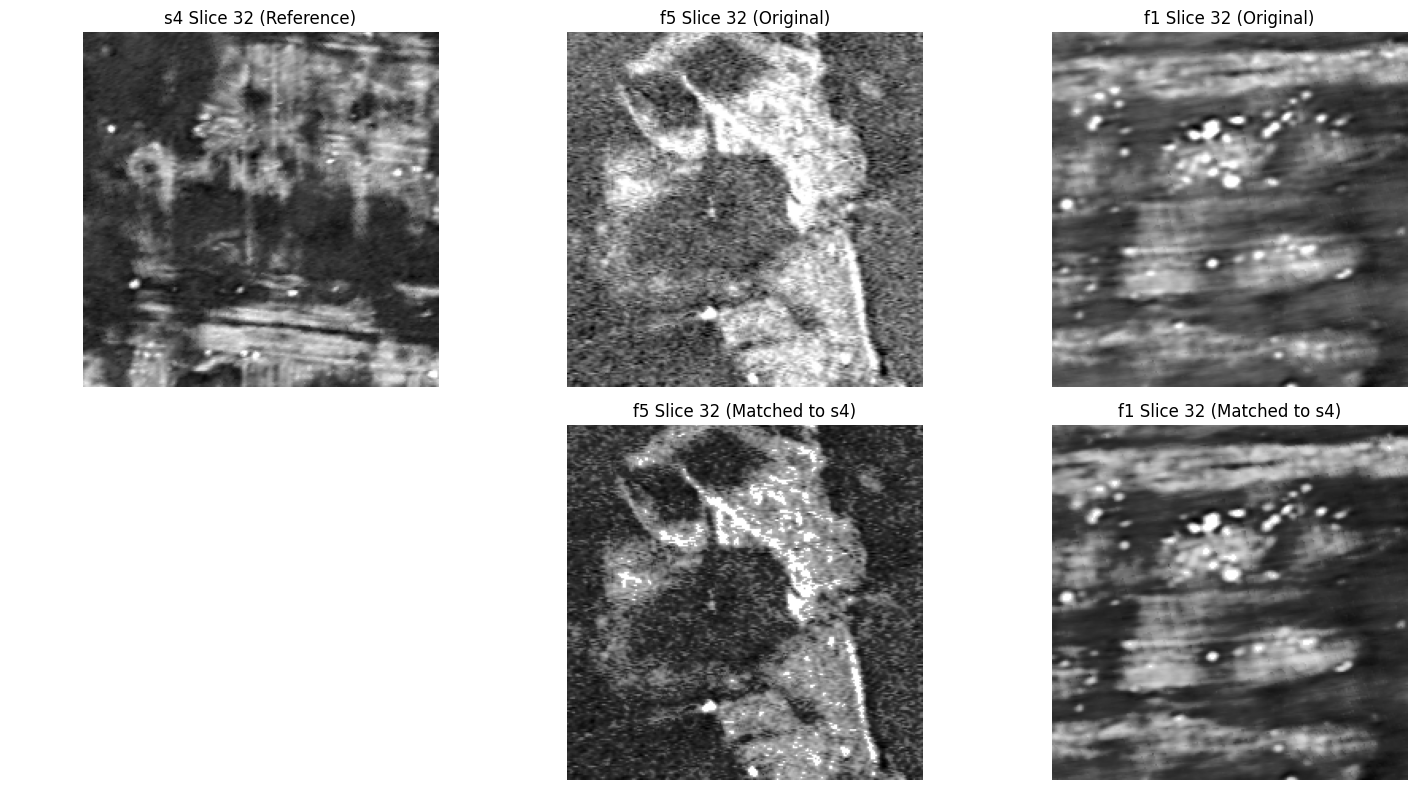

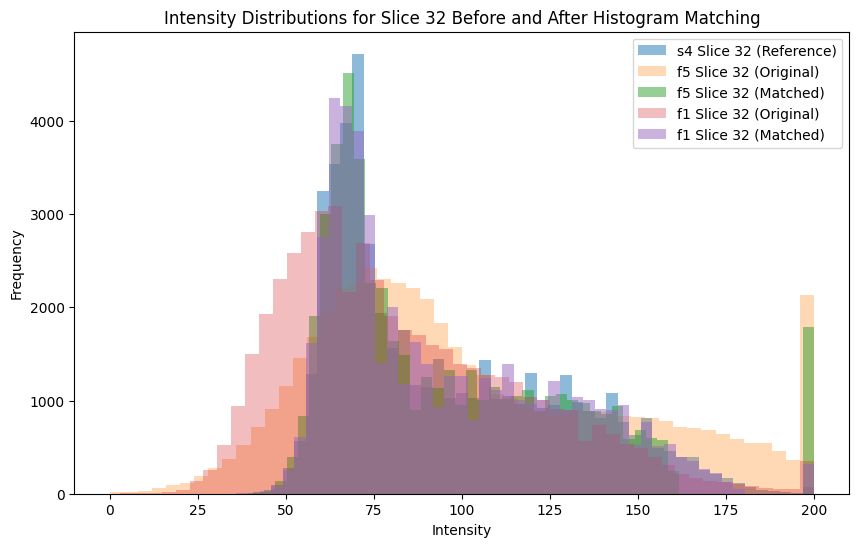

In [56]:
import torch
import numpy as np
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt

slice_idx = 32  # slice to match and visualize

# Convert tensors to NumPy for slice 32
s4_slice = s4[:, :, slice_idx].cpu().numpy().astype(np.float32)  # reference slice
f5_slice = f5[:, :, slice_idx].cpu().numpy().astype(np.float32)  # source slice 1
f1_slice = f1[:, :, slice_idx].cpu().numpy().astype(np.float32)  # source slice 2

# Histogram match each source slice to s4 slice
f5_matched_slice = match_histograms(f5_slice, s4_slice, channel_axis=None)
f1_matched_slice = match_histograms(f1_slice, s4_slice, channel_axis=None)

# Plot original vs matched images side by side
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original slices
axes[0, 0].imshow(s4_slice, cmap='gray')
axes[0, 0].set_title('s4 Slice 32 (Reference)')
axes[0, 1].imshow(f5_slice, cmap='gray')
axes[0, 1].set_title('f5 Slice 32 (Original)')
axes[0, 2].imshow(f1_slice, cmap='gray')
axes[0, 2].set_title('f1 Slice 32 (Original)')

# Matched slices
axes[1, 0].axis('off')  # empty spot for alignment
axes[1, 1].imshow(f5_matched_slice, cmap='gray')
axes[1, 1].set_title('f5 Slice 32 (Matched to s4)')
axes[1, 2].imshow(f1_matched_slice, cmap='gray')
axes[1, 2].set_title('f1 Slice 32 (Matched to s4)')

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot histograms of slices
plt.figure(figsize=(10, 6))
plt.hist(s4_slice.flatten(), bins=50, alpha=0.5, label='s4 Slice 32 (Reference)')
plt.hist(f5_slice.flatten(), bins=50, alpha=0.3, label='f5 Slice 32 (Original)')
plt.hist(f5_matched_slice.flatten(), bins=50, alpha=0.5, label='f5 Slice 32 (Matched)')
plt.hist(f1_slice.flatten(), bins=50, alpha=0.3, label='f1 Slice 32 (Original)')
plt.hist(f1_matched_slice.flatten(), bins=50, alpha=0.5, label='f1 Slice 32 (Matched)')
plt.legend()
plt.title("Intensity Distributions for Slice 32 Before and After Histogram Matching")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


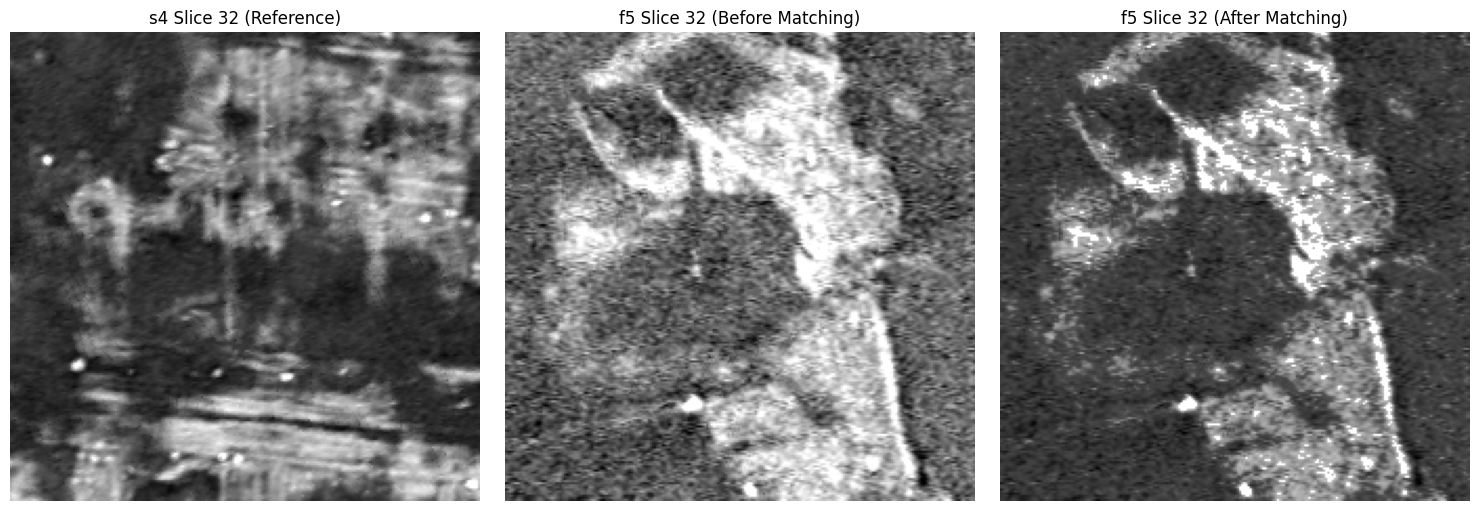

In [58]:
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms
import numpy as np
import torch

def histogram_match_block(source_tensor, reference_tensor, start_slice, num_slices=16):
    """
    Histogram match a block of `num_slices` starting at `start_slice`.
    Assumes tensors shape (H, W, D).
    """
    source_block = source_tensor[:, :, start_slice:start_slice+num_slices].cpu().numpy().astype(np.float32)
    reference_block = reference_tensor[:, :, start_slice:start_slice+num_slices].cpu().numpy().astype(np.float32)
    
    # Flatten 3D blocks to 1D
    source_flat = source_block.flatten()
    reference_flat = reference_block.flatten()
    
    # Perform histogram matching on the entire flattened block
    matched_flat = match_histograms(source_flat, reference_flat, channel_axis=None)
    
    # Reshape back to original block shape
    matched_block = matched_flat.reshape(source_block.shape)
    
    # Convert back to tensor
    matched_tensor_block = torch.from_numpy(matched_block)
    return matched_tensor_block

# Example usage:
start_idx = 24  # block start slice index
num_slices = 16

# Match f5 block to s4 reference block
matched_block = histogram_match_block(f5, s4, start_slice=start_idx, num_slices=num_slices)

# Create a copy of f5 to hold matched result without modifying original
f5_matched = f5.clone()

# Replace the 16 slices block in f5_matched with the matched block
f5_matched[:, :, start_idx:start_idx+num_slices] = matched_block

# Slice to visualize (32 is inside the matched block since 10 <= 32 < 26)
slice_idx = 32

# Extract slices as numpy arrays for plotting
s4_slice = s4[:, :, slice_idx].cpu().numpy()
f5_slice_before = f5[:, :, slice_idx].cpu().numpy()
f5_slice_after = f5_matched[:, :, slice_idx].cpu().numpy()

# Plot slices side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(s4_slice, cmap='gray')
axs[0].set_title('s4 Slice 32 (Reference)')
axs[1].imshow(f5_slice_before, cmap='gray')
axs[1].set_title('f5 Slice 32 (Before Matching)')
axs[2].imshow(f5_slice_after, cmap='gray')
axs[2].set_title('f5 Slice 32 (After Matching)')

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


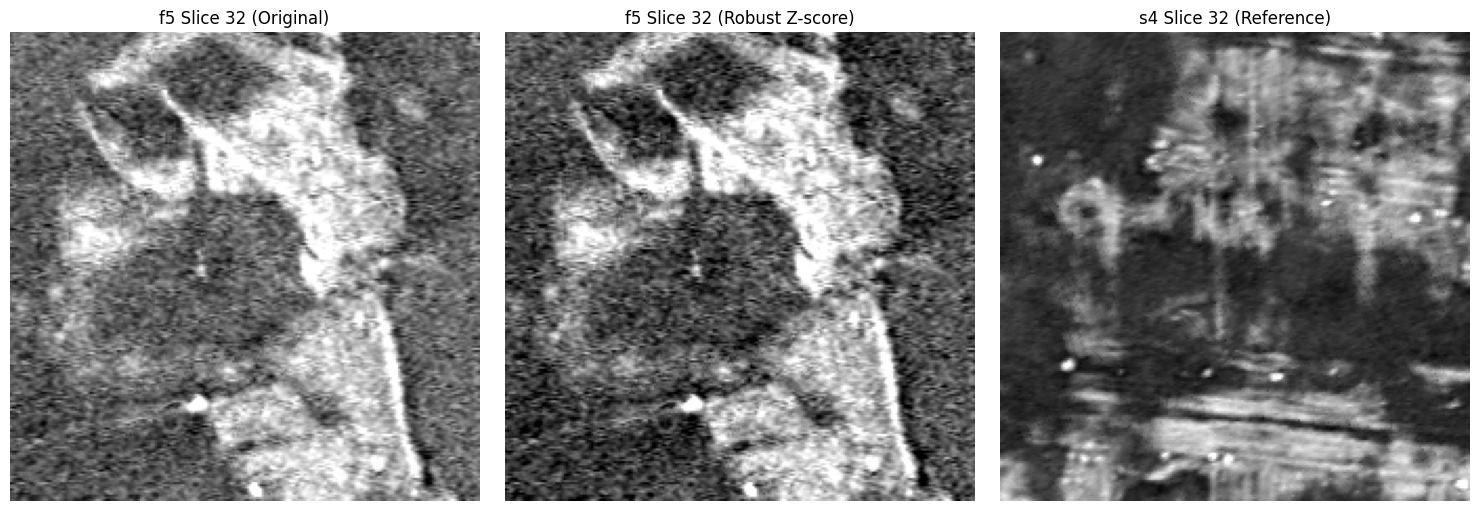

In [ ]:
import torch
import matplotlib.pyplot as plt

def robust_zscore(x, p_lo=1, p_hi=99):
    """
    Apply robust z-score normalization by clipping to [p_lo, p_hi] percentiles
    and standardizing.
    Input: x is a 3D tensor (H, W, D)
    """
    x = x.float()
    lo = torch.quantile(x.flatten(), p_lo / 100)
    hi = torch.quantile(x.flatten(), p_hi / 100)
    
    x_clipped = x.clamp(min=lo, max=hi)
    mean = x_clipped.mean()
    std = x_clipped.std()
    
    return (x_clipped - mean) / (std + 1e-8)

# --- Normalize f5 with robust z-score ---
f5_norm = robust_zscore(f5)

# --- Choose a slice to visualize ---
slice_idx = 32
f5_slice_orig = f5[:, :, slice_idx].cpu().numpy()
f5_slice_norm = f5_norm[:, :, slice_idx].cpu().numpy()
s4_slice = s4[:, :, slice_idx].cpu().numpy()

# --- Plot original, normalized, and reference ---
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(f5_slice_orig, cmap='gray')
axs[0].set_title("f5 Slice 32 (Original)")
axs[1].imshow(f5_slice_norm, cmap='gray')
axs[1].set_title("f5 Slice 32 (Robust Z-score)")
axs[2].imshow(s4_slice, cmap='gray')
axs[2].set_title("s4 Slice 32 (Reference)")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

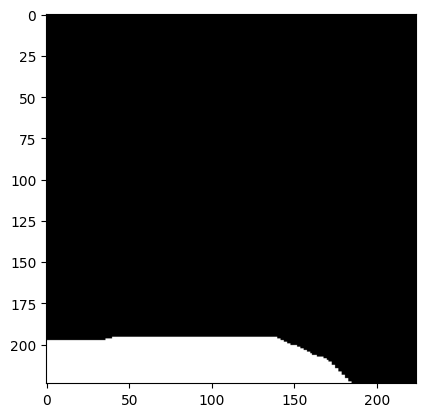

In [60]:
plt.imshow(mask_f5.cpu().numpy(), cmap='gray')

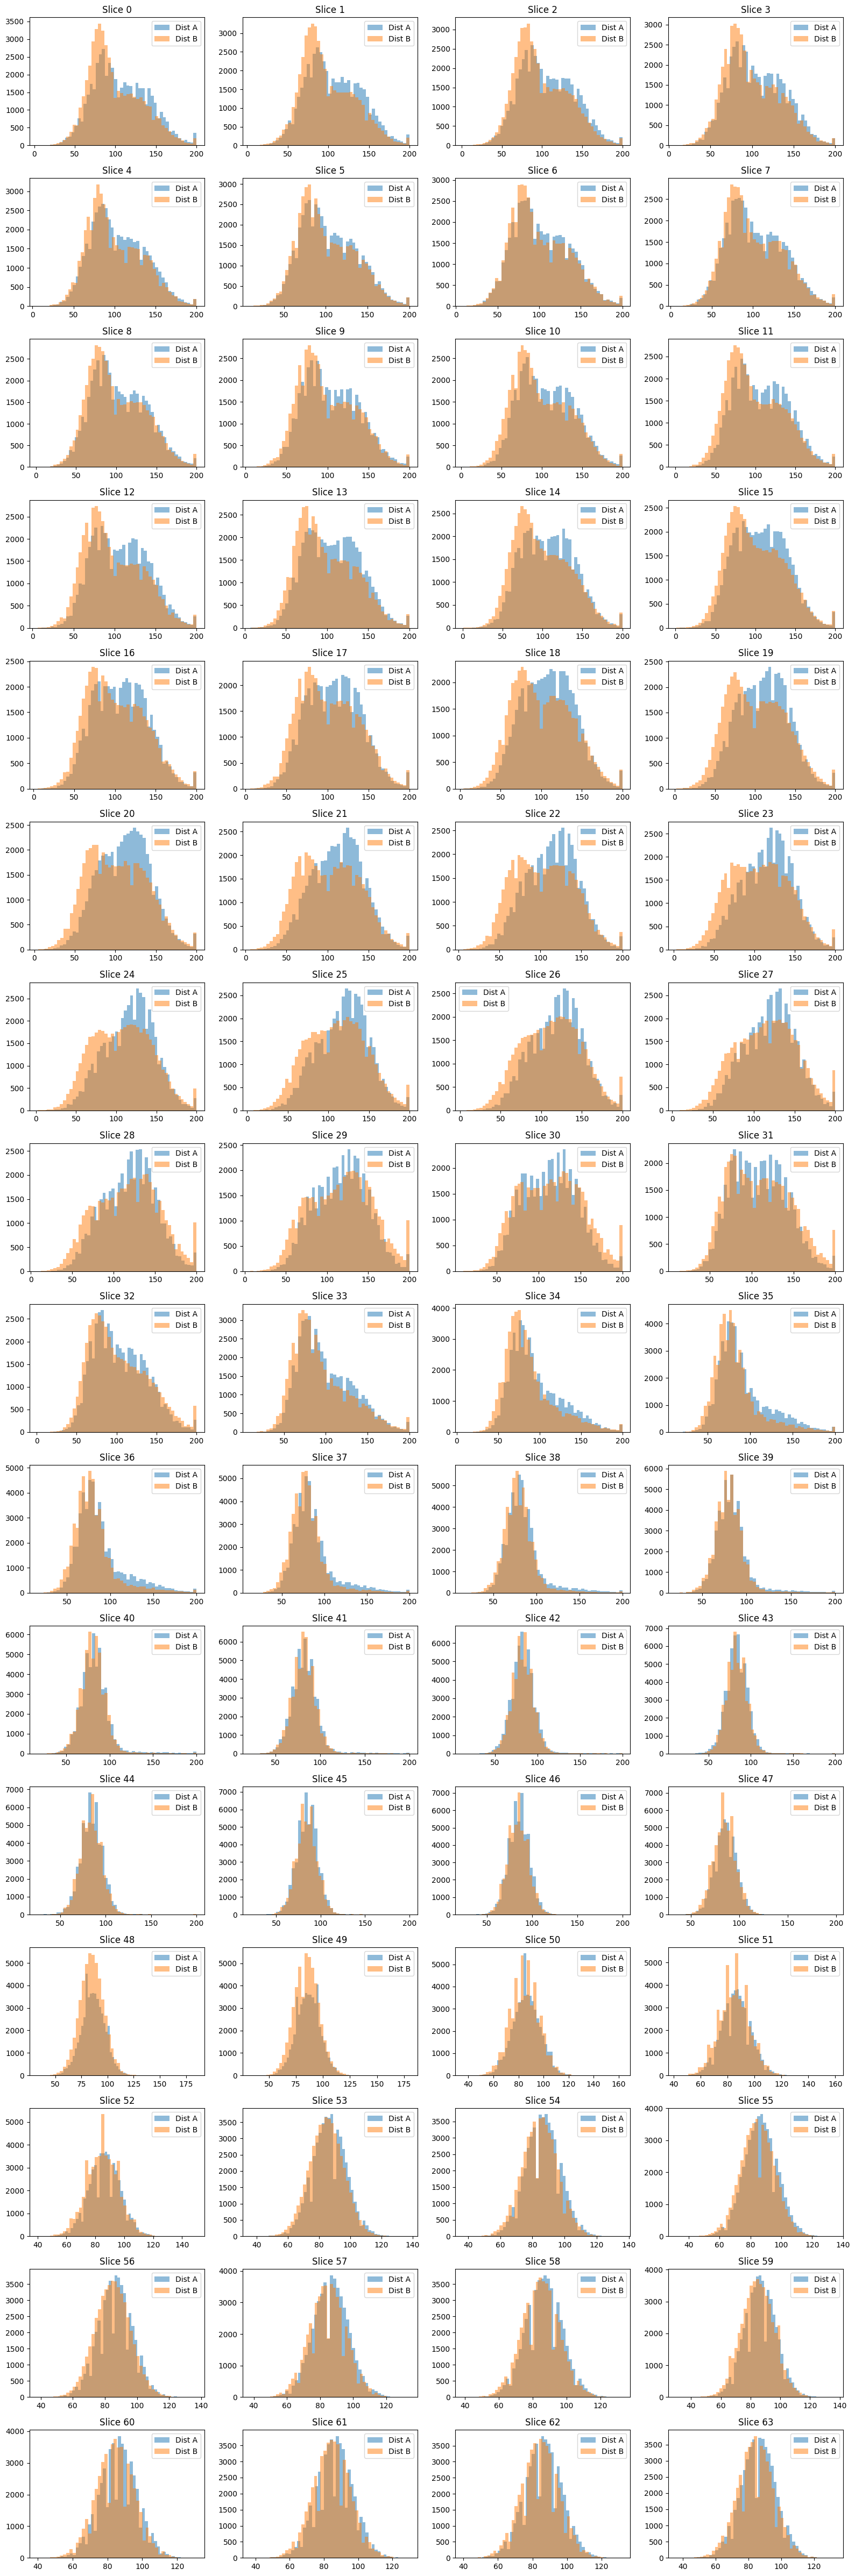

In [23]:
import torch
import matplotlib.pyplot as plt

def plot_histograms_per_layer(volume1, volume2, bins=50, max_layers=64):
    """
    Plot histogram comparisons for each slice along the depth (D) axis.
    volume1 and volume2: torch tensors of shape (H, W, D)
    """
    assert volume1.shape == volume2.shape, "Volumes must have the same shape"
    H, W, D = volume1.shape

    layers_to_show = min(D, max_layers)  # Limit number of layers plotted
    cols = 4
    rows = (layers_to_show + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    for i in range(layers_to_show):
        ax = axes[i]
        hist1 = volume1[:, :, i].flatten().numpy()
        hist2 = volume2[:, :, i].flatten().numpy()

        ax.hist(hist1, bins=bins, alpha=0.5, label='Dist A')
        ax.hist(hist2, bins=bins, alpha=0.5, label='Dist B')
        ax.set_title(f'Slice {i}')
        ax.legend()

    # Hide unused axes
    for i in range(layers_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
plot_histograms_per_layer(tensor1, tensor2)


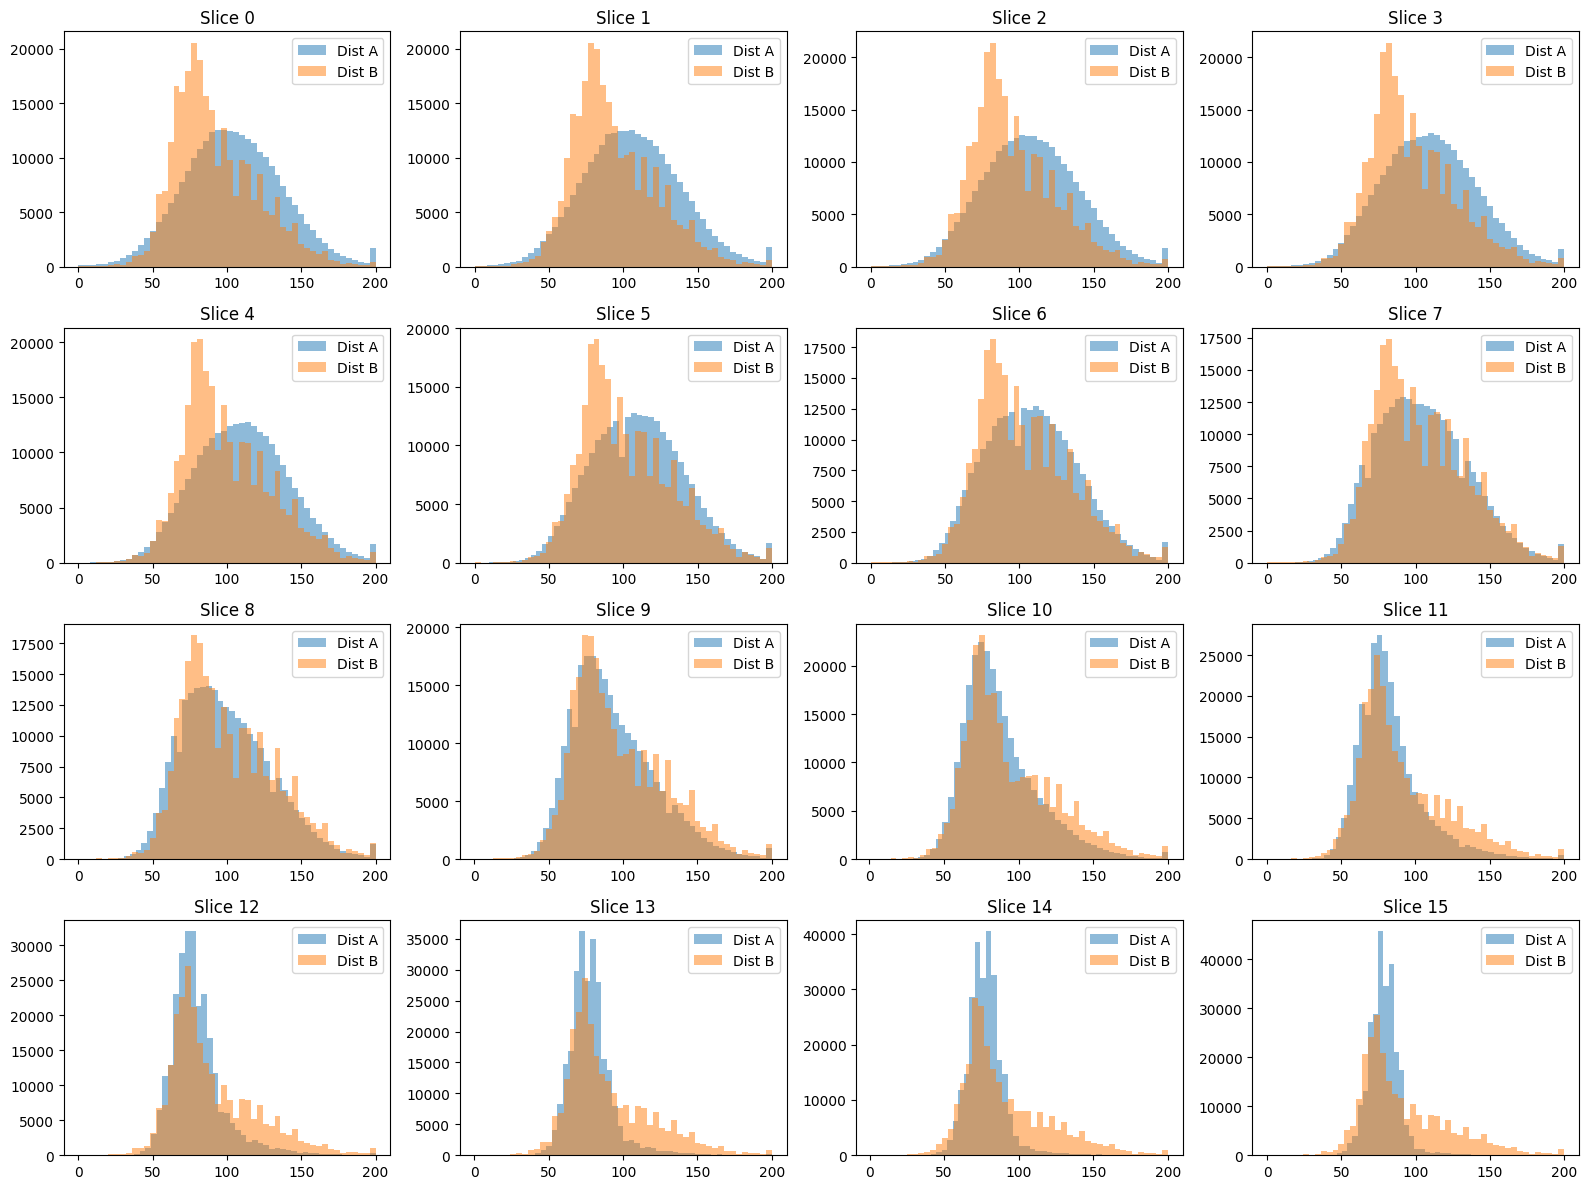

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

volume_A = tensor1.numpy()
volume_B = tensor2.numpy()

# Match histograms over the full volume
matched_volume_B = match_histograms(volume_B.astype(np.float16), volume_A, channel_axis=None)
plot_histograms_per_layer(torch.tensor(volume_A), torch.tensor(matched_volume_B))


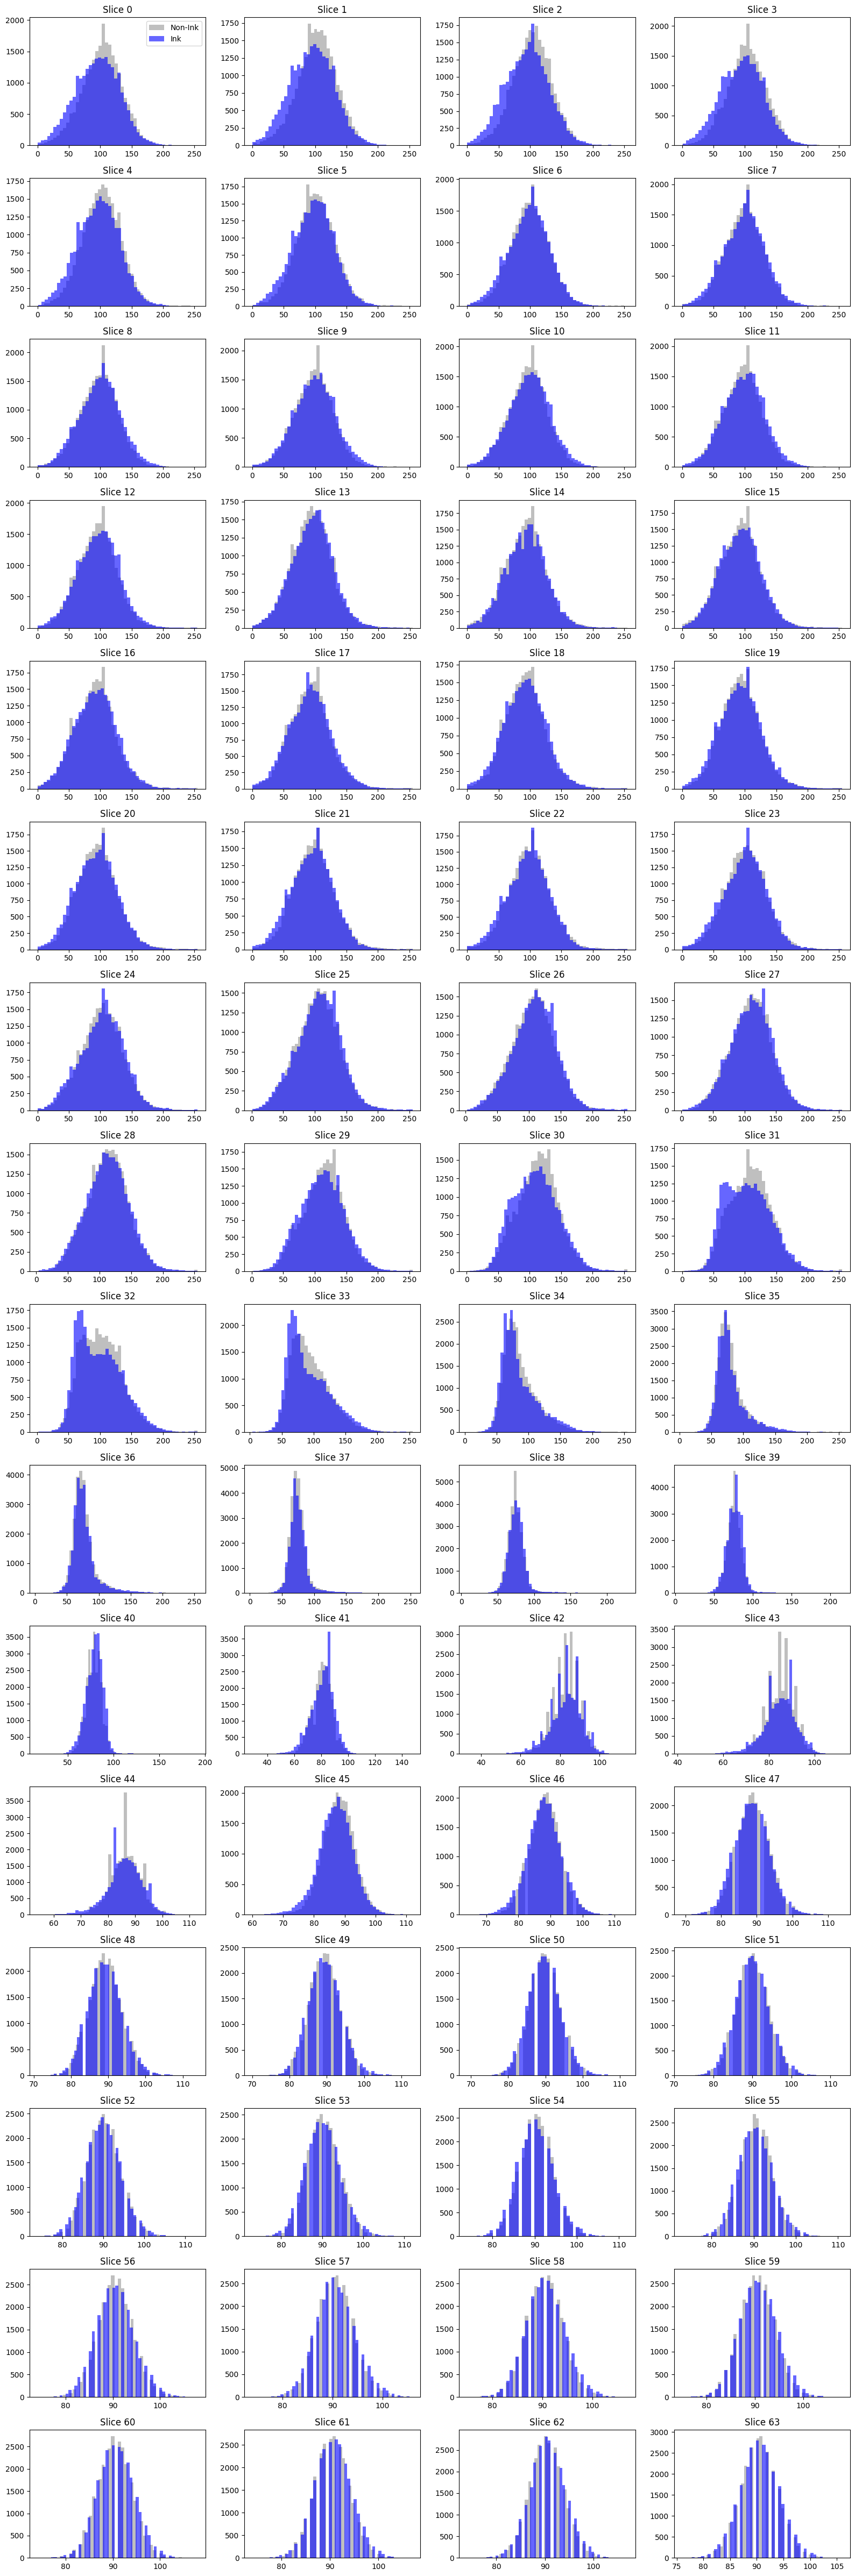

In [102]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor2_histograms_overlay(tensor2, mask2d, bins=50, max_layers=64):
    """
    For each slice of tensor2, overlay histograms of ink and non-ink regions
    defined by a 2D mask.
    """

    H, W, D = tensor2.shape
    layers_to_show = min(D, max_layers)
    cols = 4
    rows = (layers_to_show + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    mask_flat = mask2d.flatten()

    for i in range(layers_to_show):
        ax = axes[i]
        slice_flat = tensor2[:, :, i].flatten()

        ink_vals = slice_flat[mask_flat].numpy()
        nonink_vals = slice_flat[~mask_flat].numpy()

        ax.hist(nonink_vals, bins=bins, color='gray', alpha=0.5, label='Non-Ink')
        ax.hist(ink_vals, bins=bins, color='blue', alpha=0.6, label='Ink')
        ax.set_title(f"Slice {i}")
        if i == 0:
            ax.legend()

    # Hide unused subplots
    for i in range(layers_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
plot_tensor2_histograms_overlay(tensor2, mask_tensor2.to(torch.bool))


# METHODS

In [104]:
from skimage.filters import threshold_otsu
import numpy as np

def compute_slice_thresholds(volume, mask_2d, method='otsu', percentile=95):
    """
    Compute per-slice threshold using ink pixels (where mask_2d is True).
    volume: torch.Tensor (H, W, D)
    mask_2d: torch.Tensor (H, W), binary mask indicating ink regions
    method: 'otsu' or 'percentile'
    """
    volume_np = volume.numpy()
    mask_np = mask_2d.numpy()
    D = volume_np.shape[2]
    thresholds = []

    for i in range(D):
        slice_data = volume_np[:, :, i]
        ink_pixels = slice_data[mask_np == 1]

        if len(ink_pixels) == 0:
            thresholds.append(None)
            continue

        if method == 'otsu':
            thresh = threshold_otsu(ink_pixels)
        elif method == 'percentile':
            thresh = np.percentile(ink_pixels, percentile)
        else:
            raise ValueError("method must be 'otsu' or 'percentile'")

        thresholds.append(thresh)

    return thresholds

compute_slice_thresholds(tensor2, mask_tensor2.to(torch.bool))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [106]:
from scipy.stats import gaussian_kde

def kde_probabilities(volume, mask_2d, bins=256):
    """
    Estimate P(ink | intensity) using KDE.
    Returns histograms and probabilities for each slice.
    """
    volume_np = volume.numpy()
    mask_np = mask_2d.numpy()
    D = volume_np.shape[2]
    bin_edges = np.arange(256)

    kde_results = []

    for i in range(D):
        slice_data = volume_np[:, :, i].flatten()
        ink_pixels = slice_data[mask_np.flatten() == 1]
        non_ink_pixels = slice_data[mask_np.flatten() == 0]

        if len(ink_pixels) < 10 or len(non_ink_pixels) < 10:
            kde_results.append(None)
            continue

        kde_ink = gaussian_kde(ink_pixels)
        kde_non_ink = gaussian_kde(non_ink_pixels)

        ink_probs = kde_ink(bin_edges)
        non_ink_probs = kde_non_ink(bin_edges)

        # Bayes: P(ink | intensity) ∝ P(intensity | ink)
        prob_ink_given_intensity = ink_probs / (ink_probs + non_ink_probs + 1e-6)

        kde_results.append(prob_ink_given_intensity)

    return bin_edges, kde_results
kde_probabilities(tensor2, torch.tensor(mask_tensor2), bins=50)

/mnt/efs/fs1/tmp/ipykernel_24103/3333983111.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kde_probabilities(tensor2, torch.tensor(mask_tensor2), bins=50)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
from scipy.stats import entropy, wasserstein_distance

def compute_distribution_distances(volume, mask_2d, bins=256):
    volume_np = volume.numpy()
    mask_np = mask_2d.numpy()
    D = volume_np.shape[2]

    kl_scores = []
    wass_scores = []

    for i in range(D):
        slice_data = volume_np[:, :, i].flatten()
        ink_pixels = slice_data[mask_np.flatten() == 1]
        non_ink_pixels = slice_data[mask_np.flatten() == 0]

        if len(ink_pixels) < 10 or len(non_ink_pixels) < 10:
            kl_scores.append(None)
            wass_scores.append(None)
            continue

        h_ink, _ = np.histogram(ink_pixels, bins=bins, range=(0, 255), density=True)
        h_non, _ = np.histogram(non_ink_pixels, bins=bins, range=(0, 255), density=True)

        # KL divergence
        kl = entropy(h_ink + 1e-8, h_non + 1e-8)
        kl_scores.append(kl)

        # Wasserstein
        wass = wasserstein_distance(ink_pixels, non_ink_pixels)
        wass_scores.append(wass)

    return kl_scores, wass_scores

compute_distribution_distances()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_images(image_path, mask_path, alpha=0.5, mask_color=(255, 0, 0)):
    # Read images
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize mask to match image size if needed
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Convert image to RGB (OpenCV loads as BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a color mask from the grayscale mask
    color_mask = np.zeros_like(image_rgb)
    color_mask[mask > 0] = mask_color  # Apply color where mask is present

    # Overlay the mask on the image using alpha blending
    overlayed = cv2.addWeighted(image_rgb, 1 - alpha, color_mask, alpha, 0)

    # Display
    plt.figure(figsize=(10,10))
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()

# Example usage:
image_path = 'vesuvius_ink_detection/wandb/run-20250704_185043-cj0xqsqn/files/media/images/masks_230_8a11ebd5ec63e13e3e72.png'
mask_path = 'train_scrolls/PHerc0343P/PHerc0343P_inklabels.png'

overlay_images(image_path, mask_path, alpha=0.3, mask_color=(255, 0, 0))  # red mask overlay
